# Variational Autoencoder
This script demonstrates how to build a variational autoencoder with Keras.
Reference: "Auto-Encoding Variational Bayes" https://arxiv.org/abs/1312.6114

This code is strongly based on: https://github.com/fchollet/keras/blob/master/examples/variational_autoencoder_deconv.py

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda, Layer
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 760 (CNMeM is enabled with initial size: 40.0% of memory, cuDNN 5110)


In [2]:
m = 50  #= batch size
n_z = 2
n_epoch = 25
latent_dim = 2

In [3]:
# Q(z|X) -- encoder
inputs = Input(shape=(784,))
h_q = Dense(512, activation='relu')(inputs) 
mu = Dense(n_z, activation='linear')(h_q) #mean of curve
log_sigma = Dense(n_z, activation='linear')(h_q) #stddev of curve

In [4]:
def sample_z(args):
    mu, log_sigma = args
    eps = K.random_normal(shape=(m, n_z), mean=0., stddev=1.) #Random selection part
    return mu + K.exp(log_sigma / 2) * eps


# Sample z ~ Q(z|X)
z = Lambda(sample_z, output_shape=(latent_dim,))([mu, log_sigma]) #Wrap it as a layer (only 2)

In [5]:
# P(X|z) -- decoder
decoder_hidden = Dense(512, activation='relu')
decoder_out = Dense(784, activation='sigmoid')

h_p = decoder_hidden(z)
outputs = decoder_out(h_p)


In [6]:
# Overall VAE model, for reconstruction and training
vae = Model(inputs, outputs)

# Encoder model, to encode input into latent variable
# We use the mean as the output as it is the center point, the representative of the gaussian
encoder = Model(inputs, mu)

# Generator model, generate new data given latent variable z
d_in = Input(shape=(n_z,))
d_h = decoder_hidden(d_in)
d_out = decoder_out(d_h)
decoder = Model(d_in, d_out)



In [7]:
def vae_loss(y_true, y_pred):
    """ Calculate loss = reconstruction loss + KL loss for each data in minibatch """
    # E[log P(X|z)]
    recon = K.sum(K.binary_crossentropy(y_pred, y_true), axis=1)
    # D_KL(Q(z|X) || P(z|X)); calculate in closed form as both dist. are Gaussian
    kl = 0.5 * K.sum(K.exp(log_sigma) + K.square(mu) - 1. - log_sigma, axis=1)

    return recon + kl #Gewichtung?



# Train VAE on MNIST digits

In [8]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))


vae.compile(optimizer='adam', loss=vae_loss)
vae.fit(x_train, x_train, batch_size=m, epochs=n_epoch)

Epoch 1/25
60000/60000 [==============================] - 4s - loss: 181.1739     
Epoch 2/25
60000/60000 [==============================] - 4s - loss: 165.1057     
Epoch 3/25
60000/60000 [==============================] - 4s - loss: 162.0401     
Epoch 4/25
60000/60000 [==============================] - 4s - loss: 159.5622     
Epoch 5/25
60000/60000 [==============================] - 4s - loss: 157.6480     
Epoch 6/25
60000/60000 [==============================] - 4s - loss: 156.3318     
Epoch 7/25
60000/60000 [==============================] - 4s - loss: 155.3148     
Epoch 8/25
60000/60000 [==============================] - 4s - loss: 154.4374     
Epoch 9/25
60000/60000 [==============================] - 4s - loss: 153.7351     
Epoch 10/25
60000/60000 [==============================] - 4s - loss: 153.1424     
Epoch 11/25
60000/60000 [==============================] - 4s - loss: 152.5956     
Epoch 12/25
60000/60000 [==============================] - 4s - loss: 152.1121     
E

# Reconstruct the Inputs

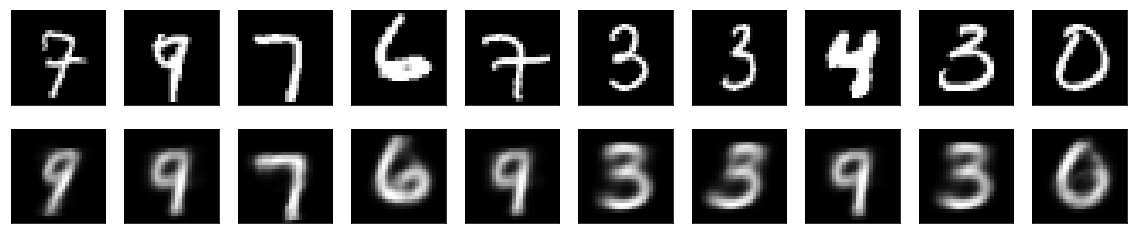

In [9]:
import matplotlib.pyplot as plt


encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    which = np.random.randint(1, len(x_test[0]))
    
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[which].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[which].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Generate digits from two random numbers:

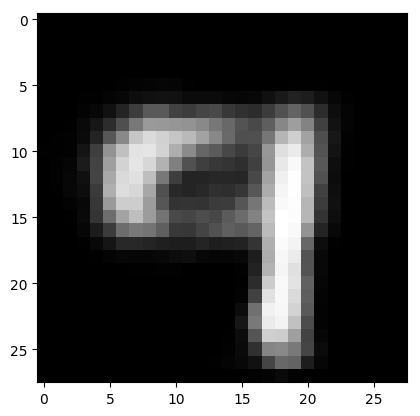

In [23]:
#Pick two random values (rather small)
z1=1
z2=3

z_sample = np.array([[z1, z2]])

#Let the decoder-network output
x_decoded = decoder.predict(z_sample)

#Display it
digit = x_decoded[0].reshape(28, 28)
plt.imshow(digit)
plt.gray()
plt.show()

# How are the inputs encoded?
This piece of code takes the coordinates z1 and z2 of all 10000 values of x_test and plots them

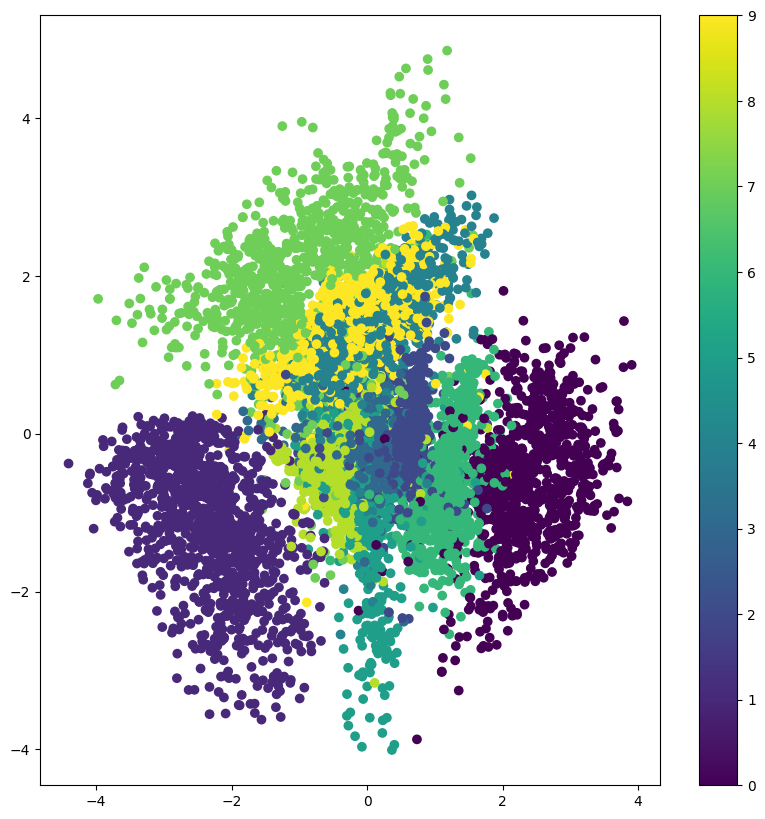

In [16]:
#Let the encoder evaluate all z's at once
x_test_encoded = encoder.predict(x_test, batch_size=m)

#Scatter them
plt.rcParams.update(plt.rcParamsDefault) #restore default setting (else it is gray)
plt.figure(figsize=(10, 10))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test[:]) #y_test is needed for the colormap
plt.colorbar()
plt.show()

# To what outputs do which z's lead?
This piece of code generates an image using the outputs of all equally spaced values of z.

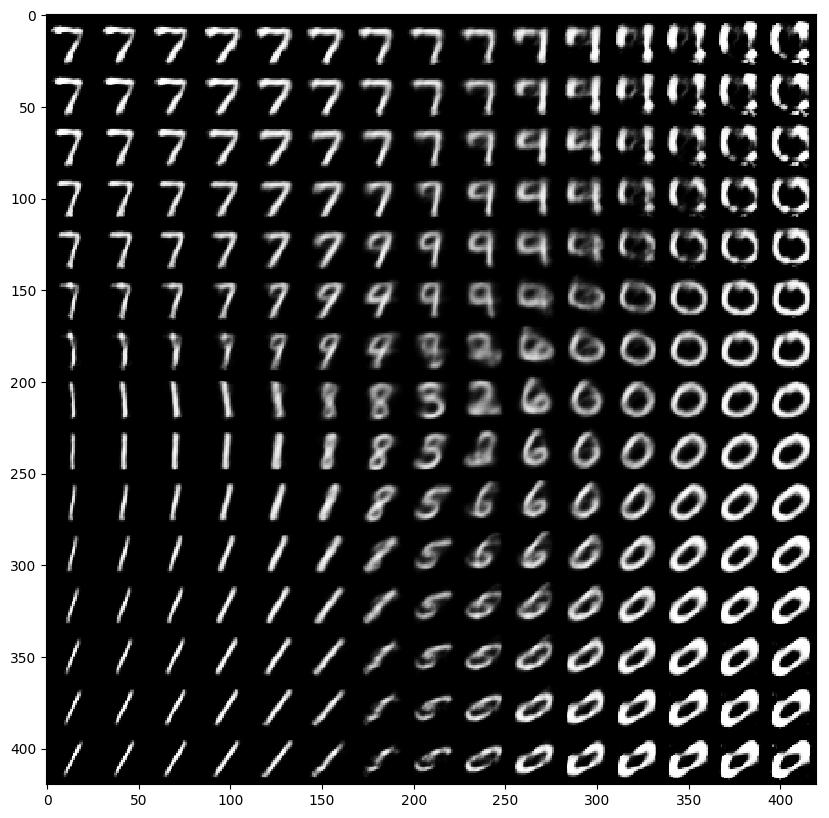

In [30]:
# sample n points within [-4, 4] standard deviations, because as seen above most of the points lie there
z1_array = np.linspace(-4, 4, n)
z2_array = np.linspace(-4, 4, n)

n = 15# figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))#init figure with zeros

for i, yi in enumerate(z2_array):
    for j, xi in enumerate(z1_array):
        z_sample = np.array([[xi, -yi]]) # (-1)*yi that the axes of the manifold are the same as the scatter
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size : (i + 1) * digit_size,
               j * digit_size : (j + 1) * digit_size] = digit # add the digit a the right place to the figure

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.gray()
plt.show()